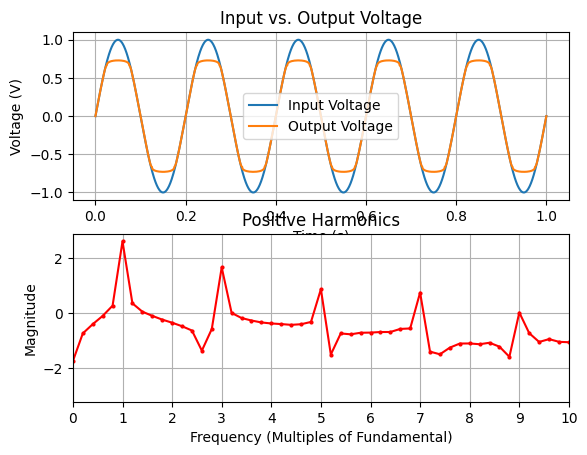

In [43]:
import numpy as np
import matplotlib.pyplot as plt

num_steps = 1000
t = np.linspace(0, 1, num_steps)  # 1 second duration

A = 1.0  # Amplitude
f = 5.0  # Frequency in Hz
omega = 2 * np.pi * f  # Angular frequency

Vin = A * np.sin(omega * t)
Vout = np.zeros(num_steps)

Is = 1e-16;
Vt = 0.026;
R = 2.2e3;
C = 0.01e-6;

fs = 1000
B0 = 2 * fs
B1 = -B0
A1 = 1

# from this paper:
# https://www.dafx.de/paper-archive/2019/DAFx2019_paper_5.pdf
# and the accompanying code:
# http://dangelo.audio/dafx2019-omega.html


k1 = 1.0 / (C * R)
k2 = (C * R) / (B0 * C * R + 1.0)
k3 = (Is * R) / (B0 * C * R + 1.0)
k4 = 1.0 / Vt
k5 = np.log((Is * R) / ((B0 * C * R + 1.0) * Vt))
k6 = B1 - A1 * B0

alpha = 9.451797158780131e-3
beta = 1.126446405111627e-1
gamma = 4.451353886588814e-1
zeta = 5.836596684310648e-1

def omega(x):
    if x <= -3.684303659906469:
        return 0
    elif x < 1.972967391708859:
        return alpha * x**3 + beta * x**2 + gamma * x + zeta
    else:
        return x - np.log(x)

p_z1 = 0
for i in range(1, num_steps):
    q = k1 * Vin[i] - p_z1;
    r = np.sign(q);
    w = k2 * q + k3 * r;
    Vout[i] = w - Vt * r * omega(k4 * r * w + k5);
    p_z1 = k6 * Vout[i] - A1 * p_z1;



plt.subplot(2, 1, 1)
plt.plot(t, Vin, label='Input Voltage')
plt.plot(t, Vout, label='Output Voltage')
plt.xlabel('Time (s)')
plt.ylabel('Voltage (V)')
plt.title('Input vs. Output Voltage')
plt.legend()
plt.grid(True)


# Plot the magnitudes of the positive harmonics using FFT
plt.subplot(2, 1, 2)
fft_result = np.fft.fft(Vout)
frequencies = np.fft.fftfreq(len(fft_result), d=0.001)

# Consider only positive harmonics
positive_harmonics_mask = frequencies >= 0
frequencies = frequencies[positive_harmonics_mask]
magnitudes = np.abs(fft_result[positive_harmonics_mask])
magnitudes_db = np.log10(magnitudes)

# Calculate the fundamental frequency based on the input parameters
fundamental_frequency = f

# Convert frequencies to multiples of the calculated fundamental frequency
multiples_of_fundamental = frequencies / fundamental_frequency

# Limit x-axis to 10 times the fundamental frequency
max_x_limit = 10
plt.plot(multiples_of_fundamental, magnitudes_db, 'ro-', markersize=2)
plt.title('Positive Harmonics')
plt.xlabel('Frequency (Multiples of Fundamental)')
plt.ylabel('Magnitude')
plt.xlim([0, max_x_limit])

# Manually set x-axis ticks
tick_positions = np.arange(0, max_x_limit + 1, 1)
plt.xticks(tick_positions)

plt.grid(True)
plt.show()
